<a href="https://colab.research.google.com/github/santule/microbe-ind/blob/main/notebooks/phosphorous_classifier_newnames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT DESCRIPTION
* Microbial Indicators:
  * Microbial count data (top 50 OTUs) for 54 samples from brisbane.
* Predict Enviornment Stress/ Resilience:
  * Predict Nitrate Classification

#### 0 - INSTALL LIBRARIES

In [1]:
!pip install boruta
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import RepeatedKFold,cross_val_score,KFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean
from numpy import std
import numpy as np
from sklearn.pipeline import Pipeline
from itertools import compress
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
import seaborn as sns
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from matplotlib import colors as plt_colors

# google drive
from google.colab import drive
drive.mount('/content/drive')
import shap
shap.initjs()

Mounted at /content/drive


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### 1 - PROCESS THE INPUT DATA FILE AND READY FOR ML

In [3]:
# read the data
otu_data_file = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/Data_for_ML_v2.csv',index_col=0)
display(otu_data_file.head(5))
print(otu_data_file.shape)

# pivot pandas
otu_data_file_t = otu_data_file.T
# remove special character
otu_data_file_t.columns = otu_data_file_t.columns.str.replace(' ', '')
display(otu_data_file_t.head(5))
print(otu_data_file_t.shape)

,139536,139537,139538,139539,139540,139541,139542,139543,139544,139545,...,139581,139582,139583,139584,139585,139586,139587,139588,139589,139590
OTU1,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTU2,0,0,0,6,12,0,8,0,10,0,...,14,0,0,0,0,0,0,0,0,0
OTU3,488,430,418,2332,2712,840,1123,107,271,0,...,141,1580,565,1507,719,541,925,36,122,102
OTU4,0,2,2,0,6,2,0,2,2,0,...,0,0,2,0,2,6,2,0,0,0
OTU5,0,0,0,0,0,0,0,0,0,2,...,0,2,0,0,0,0,0,0,0,0


(1176, 54)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1167,OTU1168,OTU1169,OTU1170,OTU1171,OTU1172,Nitrate,Nitrate_classification,Phosphorus,Phosphorus_classification
139536,0,0,488,0,0,2,19,0,0,14,...,0,2,6,11,12,0,0.01,Normal,0.05,Moderately High(3x)
139537,0,0,430,2,0,4,17,0,0,0,...,0,0,5,22,32,468,0.01,Normal,0.05,Moderately High(3x)
139538,0,0,418,2,0,0,9,0,0,0,...,0,6,8,29,8,0,0.01,Normal,0.05,Moderately High(3x)
139539,6,6,2332,0,0,0,9,0,0,0,...,0,6,4,6,8,667,0.2,High(10X),0.06,Moderately High(3x)
139540,0,12,2712,6,0,4,19,0,0,0,...,0,14,4,47,20,648,0.16,High(10X),0.13,High(5X)


(54, 1176)


label data shape (54,)
OTU data shape (54, 1172)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1163,OTU1164,OTU1165,OTU1166,OTU1167,OTU1168,OTU1169,OTU1170,OTU1171,OTU1172
139536,0,0,488,0,0,2,19,0,0,14,...,26,0,0,0,0,2,6,11,12,0
139537,0,0,430,2,0,4,17,0,0,0,...,21,0,0,0,0,0,5,22,32,468
139538,0,0,418,2,0,0,9,0,0,0,...,34,0,0,0,0,6,8,29,8,0
139539,6,6,2332,0,0,0,9,0,0,0,...,74,0,0,22,0,6,4,6,8,667
139540,0,12,2712,6,0,4,19,0,0,0,...,20,0,0,0,0,14,4,47,20,648


<Axes: ylabel='count'>

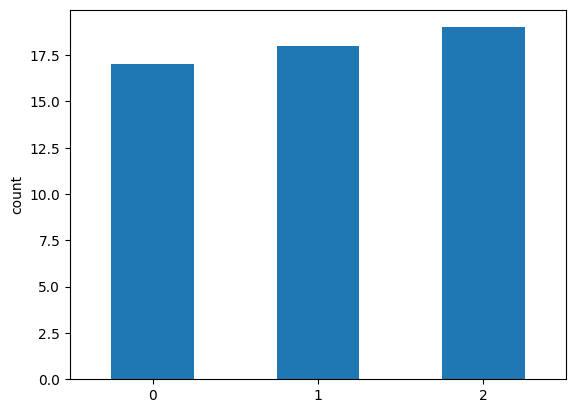

In [4]:
## LABEL ASSIGNMENT

# Phosphorous category assignment
otu_data_file_t['Phosphorus'] = otu_data_file_t['Phosphorus'].astype(float)
phosphorous_conditions = [
    (otu_data_file_t['Phosphorus'] >= 0.03) & (otu_data_file_t['Phosphorus'] < 0.1),
    (otu_data_file_t['Phosphorus'] >= 0.1) & (otu_data_file_t['Phosphorus'] < 0.15),
    (otu_data_file_t['Phosphorus'] >= 0.15)
    ]

# create a list of the values we want to assign for each condition
phosphorous_values = ['1High_3x', '2High_5x', '3Severe']

# create a new column and use np.select to assign values to it using our lists as arguments
otu_data_file_t['Phosphorus_classification_new'] = np.select(phosphorous_conditions, phosphorous_values)

# convert label to categorical value
labelencoder = LabelEncoder()
otu_data_file_t['Phosphorus_classification_cat'] = labelencoder.fit_transform(otu_data_file_t['Phosphorus_classification_new'])

# label
label_data  = otu_data_file_t['Phosphorus_classification_cat']
print('label data shape',label_data.shape)

# Remove labels
otu_data_file_t_filtered = otu_data_file_t.drop(columns=["Nitrate", "Nitrate_classification","Phosphorus","Phosphorus_classification","Phosphorus_classification_cat","Phosphorus_classification_new"],inplace=False)
print("OTU data shape",otu_data_file_t_filtered.shape)
display(otu_data_file_t_filtered.head(5))

label_data.value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count')


In [5]:
 # Filter columns by abundance criteria
otu_filter = 10
otu_data_file_t_filtered = otu_data_file_t_filtered.astype('int')
otu_data_file_t_abundant = otu_data_file_t_filtered[otu_data_file_t_filtered.columns[otu_data_file_t_filtered.sum() >= otu_filter]]
otu_data_file_t_abundant.shape

(54, 1107)

In [6]:
# Take features from indicator value analysis with p < 0.01

phos_ind_analysis = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/Indval_analyses_P2_v4.csv',index_col=0)
# remove special character
phos_ind_analysis.index = phos_ind_analysis.index.str.replace(' ', '')


# remove special character
ind_features = list(phos_ind_analysis.index.str.replace(' ', ''))
otu_data_file_t_abundant = otu_data_file_t_abundant[ind_features]
print(otu_data_file_t_abundant.shape)

(54, 39)


In [7]:
# OTU Full name file lookup creation
otu_full_name_file_df = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/OTU_ID_fullname_lookup_v2.csv')

otu_full_name_file_df.index = otu_full_name_file_df['OTU_ID']

display(otu_full_name_file_df.head(5))

otu_name_dict = otu_full_name_file_df['Short_name'].to_dict()
otu_name_dict['OTU380']


,OTU_ID,Short_name,Short_name.1,Taxonomy,Domain,Phylum,Class,Order,Family,Genus
OTU_ID,,,,,,,,,,
OTU1,OTU1,(QMZP01)unclassified,(o__QMZP01)g__,d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarc...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__QMZP01,unclassified,g__
OTU2,OTU2,(p__Aenigmatarchaeota)c__Aenigmatarchaeia,(unclassified)g__,d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarc...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,unclassified,NaN,g__
OTU3,OTU3,(UBA460)Kariarchaeum,(o__UBA460)g__Kariarchaeum,d__Archaea;p__Asgardarchaeota;c__Heimdallarcha...,d__Archaea,p__Asgardarchaeota,c__Heimdallarchaeia,o__UBA460,f__Kariarchaeaceae,g__Kariarchaeum
OTU4,OTU4,(UBA460)unclassified,(o__UBA460)unclassified,d__Archaea;p__Asgardarchaeota;c__Heimdallarcha...,d__Archaea,p__Asgardarchaeota,c__Heimdallarchaeia,o__UBA460,f__Kariarchaeaceae,unclassified
OTU5,OTU5,(UBA460)unclassified,(o__UBA460)g__,d__Archaea;p__Asgardarchaeota;c__Heimdallarcha...,d__Archaea,p__Asgardarchaeota,c__Heimdallarchaeia,o__UBA460,unclassified,g__


'(UBA817)'

#### 2 - NESTED CV - RANDOM FOREST AND KNN MODEL PERFORMANCE ESTIMATION

##### 2.1 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( KNN)

In [ ]:
## CV FOR KNN CLASSIFIER - MODEL PERFORMANCE

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([ ('vt' ,   VarianceThreshold()),
                               ('scale', StandardScaler()),
                               ('knn',   KNeighborsClassifier())])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.761 (0.187)


##### 2.2 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( RANDOM FOREST)

In [ ]:
## CV FOR RANDOM FOREST CLASSIFIER - CHOOSE FEATURES AND NUMBER OF ESTIMATORS

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([ ('vt' , VarianceThreshold()),
                               ('bt',  BorutaPy(verbose=0,estimator=RandomForestClassifier(random_state=1),n_estimators='auto',max_iter=100)),
                               ('rfc', RandomForestClassifier(random_state=1))])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.855 (0.124)


#### 3 - Train Random Forest on all dataset using Boruta for feature selection

In [8]:
# let's initialize a RF model
model = RandomForestClassifier(random_state=1)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    max_iter=100,  # number of iterations to perform,
    random_state=20
)

# train Boruta
feat_selector.fit(np.array(otu_data_file_t_abundant), np.array(label_data))

# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", otu_data_file_t_abundant.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  OTU80  - Ranking:  1
Passes the test:  OTU105  - Ranking:  1
Passes the test:  OTU297  - Ranking:  1
Passes the test:  OTU299  - Ranking:  1
Passes the test:  OTU301  - Ranking:  1
Passes the test:  OTU706  - Ranking:  1
Passes the test:  OTU712  - Ranking:  1
Passes the test:  OTU713  - Ranking:  1
Passes the test:  OTU729  - Ranking:  1
Passes the test:  OTU781  - Ranking:  1
Passes the test:  OTU1016  - Ranking:  1
Passes the test:  OTU1072  - Ranking:  1
Passes the test:  OTU1076  - Ranking:  1
Passes the test:  OTU1078  - Ranking:  1


In [9]:
# Train Ramdom Forest on full training data and list feature importance
boruta_features = list(otu_data_file_t_abundant.columns[feat_selector.support_])
print("Total Features used:",len(boruta_features))
model_pipeline_bt = Pipeline([('rfc', RandomForestClassifier(random_state=1))])
model_pipeline_bt.fit(otu_data_file_t_abundant[boruta_features],label_data)


Total Features used: 14


Pipeline(steps=[('rfc', RandomForestClassifier(random_state=1))])

#### 3 - SHAP FEATURES

In [10]:
# SHAP FEATUREE EXPLAINING TARGET VARIABLE
explainer   = shap.Explainer(model_pipeline_bt.named_steps["rfc"],seed=1)
shap_values = explainer.shap_values(otu_data_file_t_abundant[boruta_features])
shap_values[0].shape,shap_values[1].shape,shap_values[2].shape

((54, 14), (54, 14), (54, 14))

In [11]:
# SHAP FEATUREE IMPORTANCE
vals= np.abs(shap_values).mean(0).mean(0) # mean across all 3 classes across all datapoints
feature_importance = pd.DataFrame(list(zip(boruta_features,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
display(feature_importance.head(10))
shap_top_10_feature_names = list(feature_importance['col_name'])[0:10]
print(shap_top_10_feature_names)
feature_idx = [boruta_features.index(f) for f in shap_top_10_feature_names]

,col_name,feature_importance_vals
10,OTU1016,0.050849
3,OTU299,0.050612
0,OTU80,0.048440
5,OTU706,0.044632
6,OTU712,0.042602
8,OTU729,0.031876
7,OTU713,0.031182
9,OTU781,0.029875
13,OTU1078,0.029116
2,OTU297,0.029059


['OTU1016', 'OTU299', 'OTU80', 'OTU706', 'OTU712', 'OTU729', 'OTU713', 'OTU781', 'OTU1078', 'OTU297']


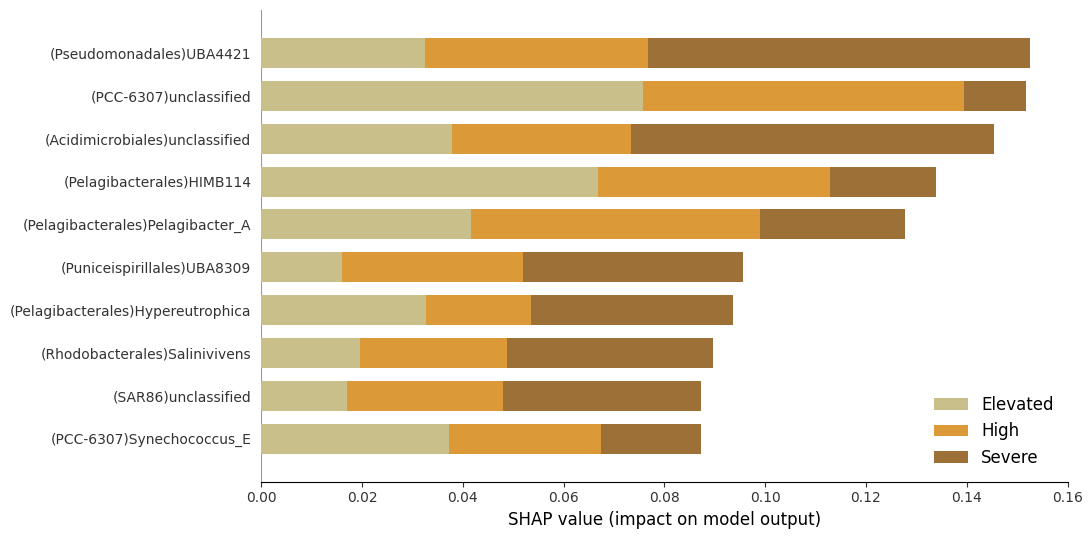

In [12]:
# colors
# set RGB tuple per class
colors = [(0.79, 0.75, 0.54),(0.86, 0.60, 0.22),(0.61, 0.44, 0.21)]

# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors))

# OTU full names
otu_full_feature_names = [otu_name_dict[c] for c in otu_data_file_t_abundant[boruta_features].columns]

# SHAP FEATUREE EXPLAINING TARGET VARIABLE
shap.summary_plot(shap_values, otu_data_file_t_abundant[boruta_features], plot_type='bar', class_inds="original",class_names=['Elevated', 'High', 'Severe'],
                  feature_names = otu_full_feature_names, max_display=10, color = cmap,show=False)  #class_names=model_pipeline_bt.named_steps["rfc"].classes_,

# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=10)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
plt.show()

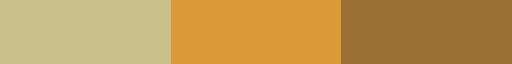

In [13]:
cmap

### 5 - MODEL EXPLANATION PER CLASS PREDICTION

#### CLASS 0 - HIGH_3X

   shap_val features
3  0.075724   OTU299
5  0.066900   OTU706
6  0.041590   OTU712
0  0.037932    OTU80
2  0.037317   OTU297
Current Label Shown: ELEVATED



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


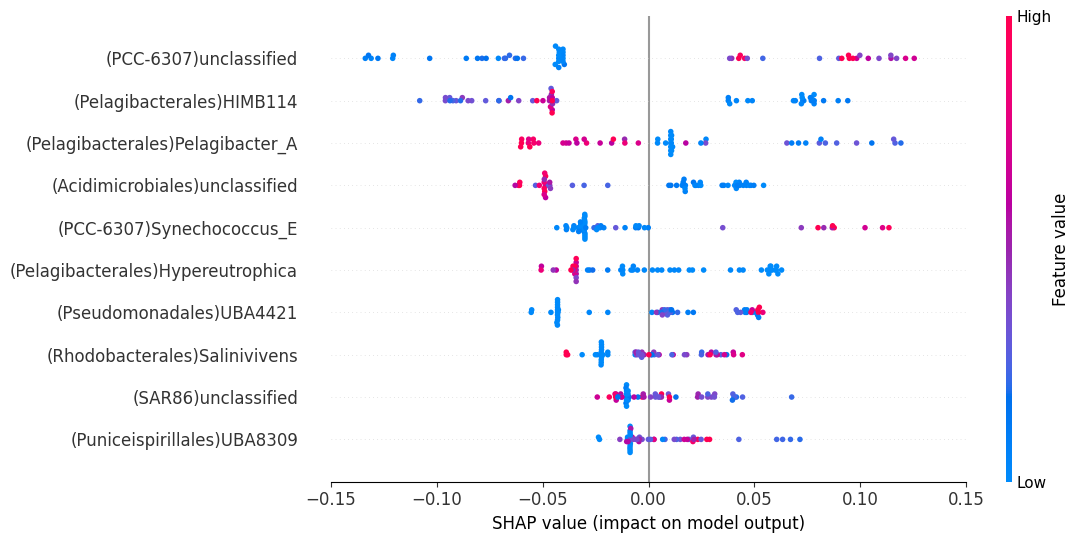

In [17]:
current_class = 0
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: ELEVATED\n')
shap.summary_plot(shap_values[current_class][:,feature_idx],features = otu_data_file_t_abundant[boruta_features].iloc[:,feature_idx], \
                   feature_names = [otu_full_feature_names[f] for f in feature_idx]  ,plot_type="dot",show=False, max_display=10)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

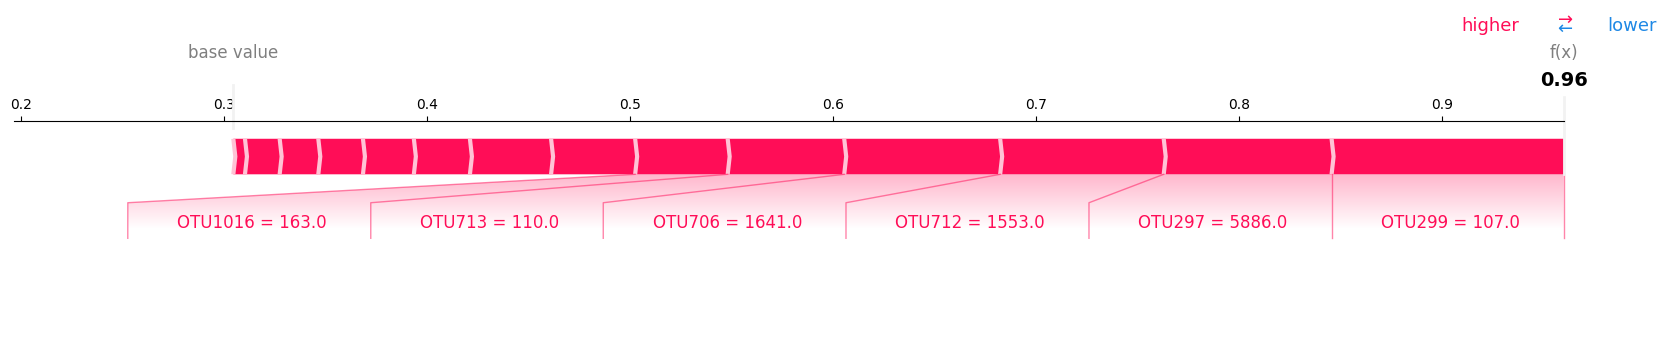

In [ ]:
# EXAMPLE 1
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[1:2,:])
shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[1:2,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### CLASS 1 - HIGH_5X

    shap_val features
3   0.063793   OTU299
6   0.057398   OTU712
5   0.045980   OTU706
10  0.044126  OTU1016
8   0.036009   OTU729
Current Label Shown: HIGH



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


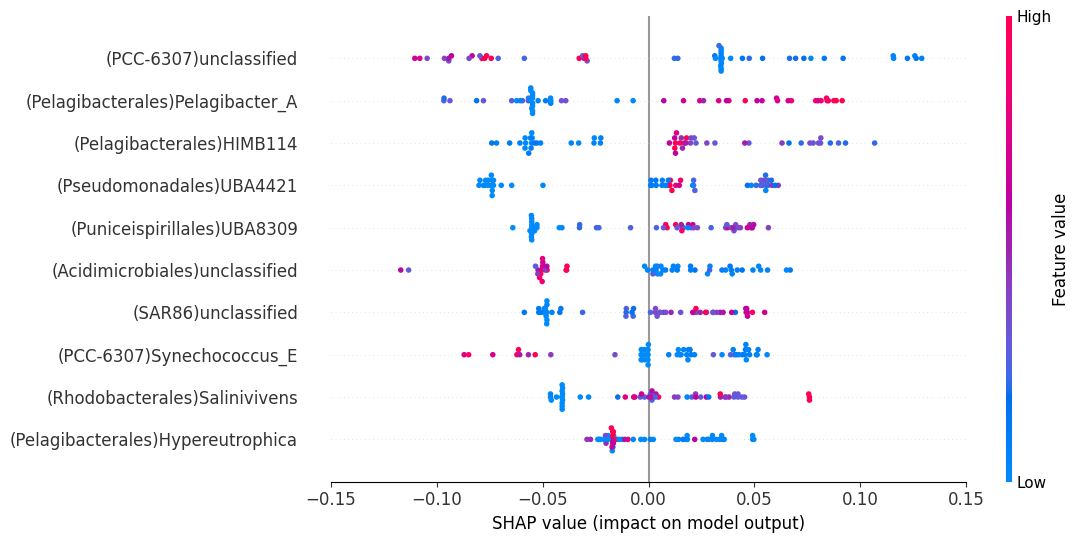

In [15]:
current_class = 1
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: HIGH\n')
shap.summary_plot(shap_values[current_class][:,feature_idx],features = otu_data_file_t_abundant[boruta_features].iloc[:,feature_idx], \
                   feature_names = [otu_full_feature_names[f] for f in feature_idx] ,plot_type="dot",show=False, max_display=10)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

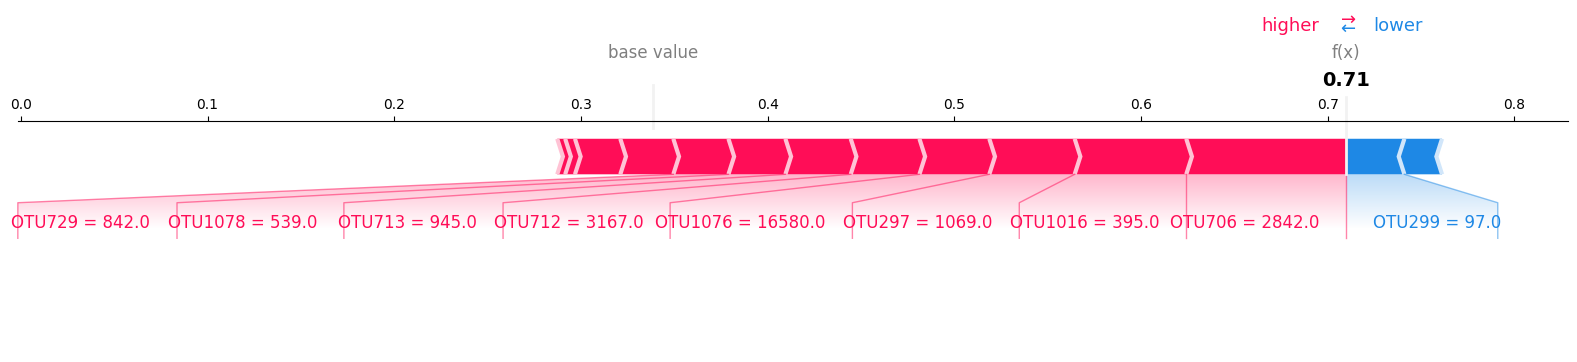

In [ ]:
# EXAMPLE 4
current_class = 1
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[4:5,:])

shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[4:5,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### CLASS 2 - SEVERE

    shap_val features
10  0.075889  OTU1016
0   0.071967    OTU80
8   0.043672   OTU729
9   0.040947   OTU781
7   0.040054   OTU713
Current Label Shown: SEVERE



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


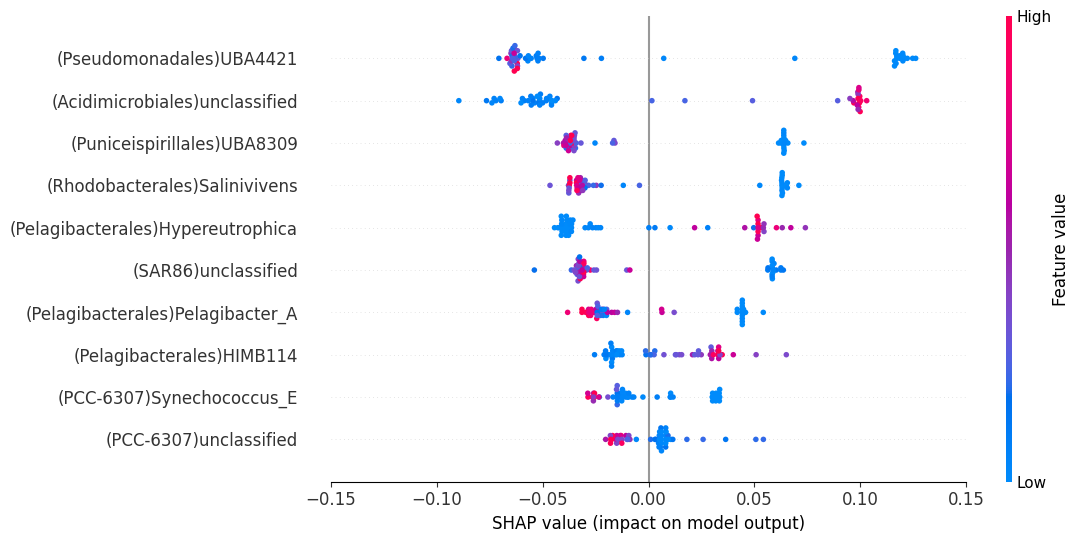

In [16]:
current_class = 2
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: SEVERE\n')
shap.summary_plot(shap_values[current_class][:,feature_idx],features = otu_data_file_t_abundant[boruta_features].iloc[:,feature_idx], \
                   feature_names = [otu_full_feature_names[f] for f in feature_idx] ,plot_type="dot",show=False, max_display=10)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

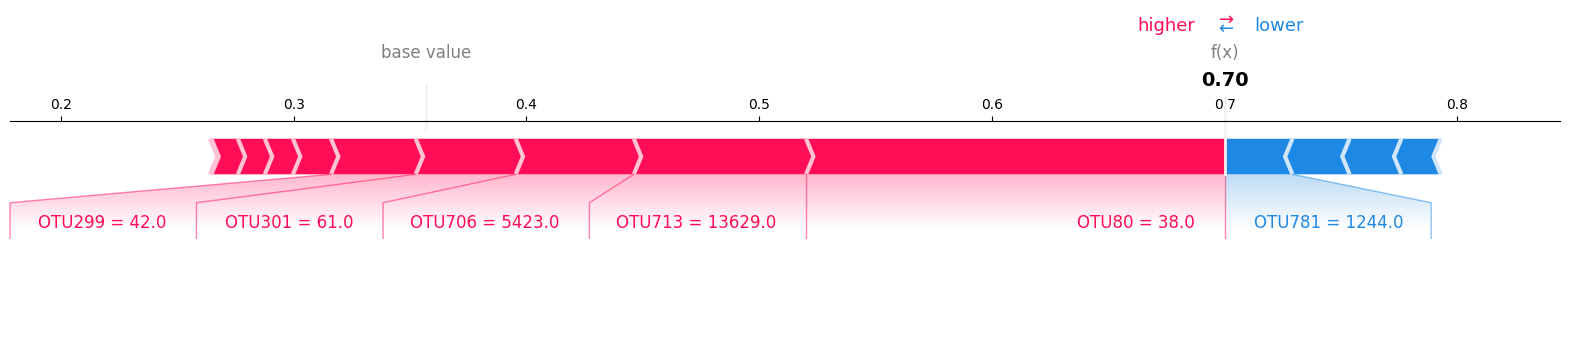

In [ ]:
# EXAMPLE 6
current_class = 2
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[6:7,:])

shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[6:7,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### 4 - UNDERSTAND PREDICTIONS

In [ ]:
# get all the data

# top 10 BT features
shap_top_10_features = list(feature_importance['col_name'].head(10))
df_rf = pd.DataFrame(otu_data_file_t_abundant[shap_top_10_features])
df_rf['true_label']      = label_data
df_rf['true_names']      = labelencoder.classes_[df_rf['true_label']]
df_rf['predicted_label'] = model_pipeline_bt.predict(otu_data_file_t_abundant[boruta_features])
df_rf.head(50).sort_values(by='true_names')

,OTU1016,OTU299,OTU80,OTU706,OTU712,OTU729,OTU713,OTU781,OTU1078,OTU297,true_label,true_names,predicted_label
139536,129,161,6,1902,1774,1143,123,2946,170,6477,0,1High_3x,0
139558,622,67,0,1385,1088,791,484,1034,247,292,0,1High_3x,0
139557,604,72,4,1831,1409,808,607,1077,306,240,0,1High_3x,0
139556,1543,179,0,505,848,868,0,2137,809,1034,0,1High_3x,0
139555,2055,189,2,1099,1762,1229,11,2808,1101,1784,0,1High_3x,0
139554,4163,501,4,172,338,3006,0,2200,223,4304,0,1High_3x,0
139565,1922,639,10,238,532,6889,52,856,176,18877,0,1High_3x,0
139566,3267,257,4,363,611,5503,93,1664,124,13841,0,1High_3x,0
139560,731,83,4,1949,1651,735,581,1432,240,648,0,1High_3x,0
139574,249,172,4,924,4385,2160,35,4032,180,11630,0,1High_3x,0
